# Wise

In [43]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [44]:
# Definir la divisa base
BASE_CURRENCY = 'EUR'

# Definir las tasas de cambio hacia la divisa base
# Las tasas son la cantidad de BASE_CURRENCY que equivale a 1 unidad de la otra divisa
EXCHANGE_RATES = {
    'EUR': 1.0,    # Divisa base
    'USD': 0.92,   # 1 USD = 0.92 EUR
    'GBP': 1.14,   # 1 GBP = 1.14 EUR
    'HUF': 0.0024, # 1 HUF = 0.0024 EUR
    'DKK': 0.13,    # 1 DKK = 0.13 EUR
    'RSD': 0.0085  # 1 RSD = 0.0085 EUR
    # Puedes añadir más divisas según sea necesario

}

In [45]:
def convert_to_base_currency(amount: float, source_currency: str) -> float:
    """
    Convierte una cantidad de una divisa fuente a la divisa base.
    
    :param amount: La cantidad en la divisa fuente.
    :param source_currency: El código de la divisa fuente (por ejemplo, 'USD', 'EUR', 'HUF', 'DKK').
    :return: La cantidad convertida a la divisa base.
    """
    # Manejar casos donde la divisa fuente no está en las tasas de cambio
    if source_currency not in EXCHANGE_RATES:
        raise ValueError(f"Tasa de cambio no definida para la divisa: {source_currency}")
    
    # Obtener la tasa de cambio
    rate = EXCHANGE_RATES[source_currency]
    
    # Convertir la cantidad a la divisa base
    return amount * rate

In [46]:
import json
import pandas as pd

# Cargar las categorías una vez al inicio
with open("clasificacion.json", "r") as file:
    CATEGORIES = json.load(file)

def categorize_expense(target_name: str) -> str:
    """
    Categoriza un gasto basado en el "target name" de la transacción.
    :param target_name: El "target name" de la transacción.
    :return: La categoría del gasto.
    """
    # Iterar sobre las categorías
    for category, keywords in CATEGORIES.items():
        # Iterar sobre la lista de palabras clave
        for keyword in keywords:
            # Si la palabra clave está en el "target name" (ignorando mayúsculas)
            if keyword.lower() in target_name.lower():
                return category
    return "Otros"

def add_category_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega una columna 'Categoría' al DataFrame basada en 'Target name'.
    :param df: El DataFrame de pandas que contiene la columna 'Target name'.
    :return: El DataFrame de pandas con una columna adicional 'Categoría'.
    """
    if 'Target name' not in df.columns:
        raise ValueError("El DataFrame no contiene la columna 'Target name'.")
    
    # Convertir todos los valores de 'Target name' a cadenas de texto y reemplazar NaN con cadenas vacías
    df['Target name'] = df['Target name'].astype(str).fillna('')
    
    # Aplicar la función categorize_expense a cada fila de 'Target name'
    df['Categoría'] = df['Target name'].apply(categorize_expense)
    return df

In [47]:
def add_month(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega una columna con el año y mes de la transacción. Se basa en la columna 'Created on'.
    :param df: El DataFrame de pandas.
    :return: El DataFrame de pandas con una columna adicional 'Año_Mes'.
    """
    # Convertir la columna 'Created on' a tipo datetime
    df["Created on"] = pd.to_datetime(df["Created on"], errors='coerce')
    
    # Verificar si hay valores NaT después de la conversión
    if df["Created on"].isnull().any():
        raise ValueError("Algunas fechas en 'Created on' no pudieron convertirse a datetime.")
    
    # Extraer el año y mes de la columna 'Created on'
    df["Año_Mes"] = df["Created on"].dt.to_period('M')
    return df

In [48]:
def convert_amounts_to_base_currency(df: pd.DataFrame, 
                                     amount_column: str = 'Target amount (after fees)', 
                                     currency_column: str = 'Target currency', 
                                     new_amount_column: str = 'Amount in EUR') -> pd.DataFrame:
    """
    Agrega una columna con las cantidades convertidas a la divisa base.
    
    :param df: El DataFrame de pandas.
    :param amount_column: El nombre de la columna que contiene las cantidades.
    :param currency_column: El nombre de la columna que contiene las divisas.
    :param new_amount_column: El nombre de la nueva columna para las cantidades convertidas.
    :return: El DataFrame de pandas con la nueva columna de cantidades convertidas.
    """
    # Verificar que las columnas necesarias existan en el DataFrame
    required_columns = {amount_column, currency_column}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"El DataFrame está perdiendo las siguientes columnas necesarias: {missing}")
    
    # Manejar posibles valores nulos en las columnas
    df[amount_column] = df[amount_column].fillna(0.0)
    df[currency_column] = df[currency_column].astype(str).fillna(BASE_CURRENCY)
    
    # Aplicar la conversión a cada fila
    df[new_amount_column] = df.apply(
        lambda row: convert_to_base_currency(row[amount_column], row[currency_column]), axis=1
    )
    
    return df

In [49]:
def net_amount_per_month(df: pd.DataFrame) -> pd.Series:
    """
    Calcula la cantidad neta por mes. Se basa en las columnas 'Amount in EUR' y 'Direction'. 
    'Direction' es 'OUT' si la transacción es un gasto y 'IN' si es un ingreso.
    
    :param df: El DataFrame de pandas que contiene al menos las columnas 'Año_Mes', 
               'Amount in EUR' y 'Direction'.
    :return: Una Serie de pandas con el neto por mes.
    """
    # Verificar que las columnas necesarias existan en el DataFrame
    required_columns = {'Año_Mes', 'Amount in EUR', 'Direction'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"El DataFrame está perdiendo las siguientes columnas necesarias: {missing}")
    
    # Separar ingresos y gastos
    ingresos = df[df['Direction'].str.upper() == 'IN'].groupby('Año_Mes')['Amount in EUR'].sum()
    gastos = df[df['Direction'].str.upper() == 'OUT'].groupby('Año_Mes')['Amount in EUR'].sum()
    
    # Combinar ingresos y gastos, llenando valores faltantes con 0
    neto = ingresos.subtract(gastos, fill_value=0)
    
    # Opcional: Convertir el índice de Period a string para una mejor legibilidad
    neto.index = neto.index.astype(str)
    
    return neto

In [50]:

def expenses_per_category_per_month(df: pd.DataFrame, amount_column: str = 'Amount in EUR') -> pd.DataFrame:
    """
    Calcula el dinero gastado en cada categoría por mes.
    Se basa en las columnas 'Año_Mes', 'Categoría', 'Amount in EUR' y 'Direction'.
    
    :param df: El DataFrame de pandas que contiene las columnas necesarias.
    :param amount_column: El nombre de la columna que contiene las cantidades en la divisa base.
    :return: Un DataFrame con el dinero gastado por categoría y mes.
    """
    # Verificar que las columnas necesarias existan en el DataFrame
    required_columns = {'Año_Mes', 'Categoría', amount_column, 'Direction'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"El DataFrame está perdiendo las siguientes columnas necesarias: {missing}")
    
    # Filtrar solo las transacciones de gastos
    gastos = df[df['Direction'].str.upper() == 'OUT'].copy()
    
    # Agrupar por 'Año_Mes' y 'Categoría' y sumar los montos
    gastos_agrupados = gastos.groupby(['Año_Mes', 'Categoría'])[amount_column].sum().reset_index()
    
    # Pivotar el DataFrame para tener las categorías como columnas
    gastos_pivot = gastos_agrupados.pivot(index='Año_Mes', columns='Categoría', values=amount_column).fillna(0)
    
    # Ordenar el índice por fecha
    gastos_pivot = gastos_pivot.sort_index()
    
    return gastos_pivot

In [51]:
def plot_expenses(gastos_pivot: pd.DataFrame, currency: str = BASE_CURRENCY):
    """
    Genera un gráfico de barras apiladas de los gastos por categoría y mes.
    :param gastos_pivot: DataFrame con los gastos por categoría y mes.
    :param currency: Código de la divisa base para las etiquetas.
    """
    gastos_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title(f'Gastos por Categoría y Mes ({currency})')
    plt.xlabel('Mes')
    plt.ylabel(f'Monto Gastado ({currency})')
    plt.legend(title='Categoría')
    plt.tight_layout()
    plt.show()

In [52]:
file_path = "transaction-history.csv"
expenses_data = pd.read_csv(file_path)

In [53]:
# Agregar la columna 'Año_Mes'
expenses_data = add_month(expenses_data)

# Agregar la columna 'Categoría'
expenses_data = add_category_column(expenses_data)

# Convertir las cantidades a la divisa base
expenses_data = convert_amounts_to_base_currency(expenses_data)

expenses_data.head()

,ID,Status,Direction,Created on,Finished on,Source fee amount,Source fee currency,Target fee amount,Target fee currency,Source name,...,Target name,Target amount (after fees),Target currency,Exchange rate,Reference,Batch,Created by,Año_Mes,Categoría,Amount in EUR
0,CARD_TRANSACTION-2078197818,COMPLETED,OUT,2024-12-20 10:26:28,2024-12-20 10:26:28,0.0,EUR,NaN,NaN,Daniel Jose Moreno Perez,...,Mercadona,1.95,EUR,1.0,NaN,NaN,Daniel Jose Moreno Perez,2024-12,supermercado,1.95
1,CARD_TRANSACTION-2078156792,COMPLETED,OUT,2024-12-20 10:13:12,2024-12-20 10:13:12,0.0,EUR,NaN,NaN,Daniel Jose Moreno Perez,...,El Camioncito,2.90,EUR,1.0,NaN,NaN,Daniel Jose Moreno Perez,2024-12,salir,2.90
2,CARD_TRANSACTION-2078091817,COMPLETED,OUT,2024-12-20 09:51:51,2024-12-20 09:51:51,0.0,EUR,NaN,NaN,Daniel Jose Moreno Perez,...,Clemente Peluquero,13.00,EUR,1.0,NaN,NaN,Daniel Jose Moreno Perez,2024-12,Otros,13.00
3,CARD_TRANSACTION-2077103338,COMPLETED,OUT,2024-12-20 00:27:34,2024-12-20 00:27:34,0.0,EUR,NaN,NaN,Daniel Jose Moreno Perez,...,Damajuana,7.00,EUR,1.0,NaN,NaN,Daniel Jose Moreno Perez,2024-12,salir,7.00
4,CARD_TRANSACTION-2077081855,COMPLETED,OUT,2024-12-20 00:10:05,2024-12-20 00:10:05,0.0,EUR,NaN,NaN,Daniel Jose Moreno Perez,...,Damajuana,7.50,EUR,1.0,NaN,NaN,Daniel Jose Moreno Perez,2024-12,salir,7.50


In [54]:
# Neto por mes
neto_mensual = net_amount_per_month(expenses_data)
print("Neto por mes:")
print(neto_mensual)

Neto por mes:
Año_Mes
2024-03     214.820000
2024-04    -336.780000
2024-05     859.050000
2024-06    -303.950000
2024-07     958.672760
2024-08    -181.309405
2024-09    1484.540000
2024-10   -2727.891700
2024-11    1003.630000
2024-12    -480.150000
Name: Amount in EUR, dtype: float64


In [55]:
# Gastos por categoría por mes
gastos_por_categoria = expenses_per_category_per_month(expenses_data)
print("\nGastos por categoría por mes:")
print(gastos_por_categoria)


Gastos por categoría por mes:
Categoría        Otros  lingoda    ropa  salir  supermercado  viajar  vuelos
Año_Mes                                                                     
2024-03     183.200000     0.00    0.00    0.0         2.980    0.00    0.00
2024-04     745.460000    80.99    0.00    0.0       129.240    0.00    0.00
2024-05     686.660000     0.00   72.39    0.0       126.270    0.00    0.00
2024-06     724.280000    79.99   34.98    0.0       116.070    0.00  104.71
2024-07    1512.557240     0.00   19.97    1.5       102.250    0.00    0.00
2024-08    2371.189405    79.99   17.00    0.0       110.990    0.00    0.00
2024-09     817.480000    79.99   75.00    0.0       107.840    0.00  125.79
2024-10    2498.479700    79.99  130.40   14.5       147.512    0.00    0.00
2024-11     542.910000    79.99   14.97    0.0       253.910  352.66  167.11
2024-12     180.090000     0.00    0.00   35.4       137.180    0.00  127.55


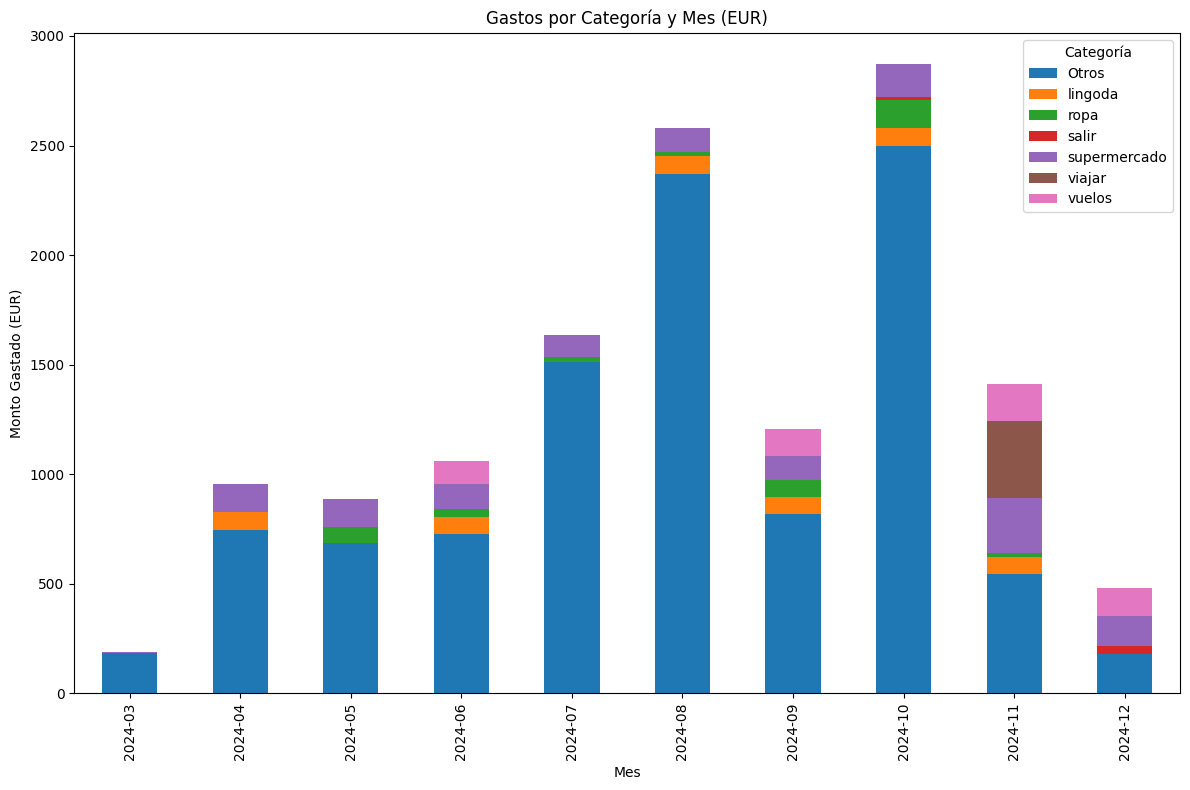

In [56]:
# Visualizar los gastos por categoría y mes
plot_expenses(gastos_por_categoria)

# Revolut

In [59]:
# Read the data from the CSV file
data = pd.read_csv("revolut_2024-01-01_2024-12-26_en-gb_2a5a91.csv")
data.head()

,Type,Product,Started Date,Completed Date,Description,Amount,Fee,Currency,State,Balance
0,CARD_PAYMENT,Current,2023-12-31 18:06:20,2024-01-01 16:20:04,La Torneria,-13.00,0.0,EUR,COMPLETED,13.05
1,TOPUP,Current,2024-01-01 23:28:46,2024-01-01 23:28:50,Top-Up by *7797,90.00,0.0,EUR,COMPLETED,103.05
2,TOPUP,Current,2024-01-04 10:19:23,2024-01-04 10:19:45,Top-Up by *7797,160.00,0.0,EUR,COMPLETED,263.05
3,CARD_PAYMENT,Current,2024-01-03 18:04:05,2024-01-04 12:22:01,Activaclub Jerez,-85.80,0.0,EUR,COMPLETED,177.25
4,CARD_PAYMENT,Current,2024-01-03 17:34:11,2024-01-04 13:36:05,Decathlon,-14.99,0.0,EUR,COMPLETED,162.26


In [60]:
# Remove rows with "top-up" in "Description" column
data = data[~data["Description"].str.contains("top-up", case=False)]
data

,Type,Product,Started Date,Completed Date,Description,Amount,Fee,Currency,State,Balance
0,CARD_PAYMENT,Current,2023-12-31 18:06:20,2024-01-01 16:20:04,La Torneria,-13.00,0.0,EUR,COMPLETED,13.05
3,CARD_PAYMENT,Current,2024-01-03 18:04:05,2024-01-04 12:22:01,Activaclub Jerez,-85.80,0.0,EUR,COMPLETED,177.25
4,CARD_PAYMENT,Current,2024-01-03 17:34:11,2024-01-04 13:36:05,Decathlon,-14.99,0.0,EUR,COMPLETED,162.26
5,CARD_REFUND,Current,2024-01-03 17:33:33,2024-01-04 13:39:00,Decathlon,24.99,0.0,EUR,COMPLETED,187.25
6,CARD_PAYMENT,Current,2024-01-04 10:22:46,2024-01-05 10:59:18,Lingoda,-127.99,0.0,EUR,COMPLETED,59.26
...,...,...,...,...,...,...,...,...,...,...
371,TRANSFER,Current,2024-12-19 22:22:45,2024-12-19 22:22:45,Bizum payment to: Daniel D.F.,-18.00,0.0,EUR,COMPLETED,110.96
372,TOPUP,Current,2024-12-21 16:40:26,2024-12-21 16:40:26,Bizum payment from: Jaime Salvador R.G.,16.70,0.0,EUR,COMPLETED,127.66
373,TRANSFER,Current,2024-12-22 20:37:40,2024-12-22 20:37:41,Bizum payment to: Pablo R.S.,-3.50,0.0,EUR,COMPLETED,124.16
374,TOPUP,Current,2024-12-22 21:38:17,2024-12-22 21:38:17,Bizum payment from: Pablo R.S.,1.90,0.0,EUR,COMPLETED,126.06


# Probar

In [74]:
# modules/WiseTracker.py

import json
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Optional

from modules.utilities import load_categories, load_expenses

class WiseTracker:
    def __init__(self, categories_path: str, exchange_rates: Dict[str, float], base_currency: str = 'EUR', csv_path: str = 'transaction-history.csv'):
        self.base_currency = base_currency
        self.exchange_rates = exchange_rates
        self.categories_path = categories_path
        self.categories = self._load_categories(categories_path)
        self.df = load_expenses(csv_path=csv_path)
        self.process_data()
        print(self.df.head())

    def _load_categories(self, path: str) -> Dict[str, list]:
        try:
            with open(path, "r", encoding='utf-8') as file:
                categories = json.load(file)
            return categories
        except FileNotFoundError:
            print(f"No se encontró el archivo de categorías en: {path}")
            return {}
        except json.JSONDecodeError:
            print(f"El archivo de categorías en {path} no es un JSON válido.")
            return {}

    def save_categories(self):
        try:
            with open(self.categories_path, "w", encoding='utf-8') as file:
                json.dump(self.categories, file, ensure_ascii=False, indent=4)
            print("Categorías guardadas exitosamente.")
        except Exception as e:
            print(f"Error al guardar las categorías: {e}")

    def convert_to_base_currency(self, amount: float, source_currency: str) -> float:
        if source_currency not in self.exchange_rates:
            raise ValueError(f"Tasa de cambio no definida para la divisa: {source_currency}")
        rate = self.exchange_rates[source_currency]
        return amount * rate

    def categorize_expense(self, target_name: str) -> str:
        for category, keywords in self.categories.items():
            for keyword in keywords:
                if keyword.lower() in target_name.lower():
                    return category
        return "Otros"

    def add_category_column(self):
        if 'Target name' not in self.df.columns:
            print("El DataFrame no contiene la columna 'Target name'.")
            return
        
        self.df['Target name'] = self.df['Target name'].astype(str).fillna('')
        self.df['Categoría'] = self.df['Target name'].apply(self.categorize_expense)
        print("Columna 'Categoría' agregada exitosamente.")

    def add_month_column(self):
        if 'Created on' not in self.df.columns:
            print("El DataFrame no contiene la columna 'Created on'.")
            return
        
        self.df["Created on"] = pd.to_datetime(self.df["Created on"], errors='coerce')
        if self.df["Created on"].isnull().any():
            print("Algunas fechas en 'Created on' no pudieron convertirse a datetime.")
        
        self.df["Año_Mes"] = self.df["Created on"].dt.to_period('M')
        print("Columna 'Año_Mes' agregada exitosamente.")

    def convert_amounts_to_base_currency(self, 
                                         amount_column: str = 'Target amount (after fees)', 
                                         currency_column: str = 'Target currency', 
                                         new_amount_column: str = 'Amount in EUR'):
        required_columns = {amount_column, currency_column}
        if not required_columns.issubset(self.df.columns):
            missing = required_columns - set(self.df.columns)
            print(f"El DataFrame está perdiendo las siguientes columnas necesarias: {missing}")
            return
        
        self.df[amount_column] = pd.to_numeric(self.df[amount_column], errors='coerce').fillna(0.0)
        self.df[currency_column] = self.df[currency_column].astype(str).fillna(self.base_currency)
        
        self.df[new_amount_column] = self.df.apply(
            lambda row: self.convert_to_base_currency(row[amount_column], row[currency_column]), axis=1
        )
        print(f"Columna '{new_amount_column}' agregada exitosamente.")

    def process_data(self):
        # Recalcular las columnas necesarias cada vez que se procesa
        self.add_category_column()
        self.add_month_column()
        self.convert_amounts_to_base_currency()
        self.add_category_column()
        print("Procesamiento de datos completado.")

    def net_amount_per_month(self) -> pd.Series:
        required_columns = {'Año_Mes', 'Amount in EUR', 'Direction'}
        if not required_columns.issubset(self.df.columns):
            missing = required_columns - set(self.df.columns)
            raise ValueError(f"El DataFrame está perdiendo las siguientes columnas necesarias: {missing}")
        
        ingresos = self.df[self.df['Direction'].str.upper() == 'IN'].groupby('Año_Mes')['Amount in EUR'].sum()
        gastos = self.df[self.df['Direction'].str.upper() == 'OUT'].groupby('Año_Mes')['Amount in EUR'].sum()
        
        neto = ingresos.subtract(gastos, fill_value=0)
        neto.index = neto.index.astype(str)
        return neto

    def expenses_per_category_per_month(self, amount_column: str = 'Amount in EUR') -> pd.DataFrame:
        required_columns = {'Año_Mes', 'Categoría', amount_column, 'Direction'}
        if not required_columns.issubset(self.df.columns):
            missing = required_columns - set(self.df.columns)
            raise ValueError(f"El DataFrame está perdiendo las siguientes columnas necesarias: {missing}")
        
        gastos = self.df[self.df['Direction'].str.upper() == 'OUT'].copy()
        gastos_agrupados = gastos.groupby(['Año_Mes', 'Categoría'])[amount_column].sum().reset_index()
        gastos_pivot = gastos_agrupados.pivot(index='Año_Mes', columns='Categoría', values=amount_column).fillna(0)
        gastos_pivot = gastos_pivot.sort_index()
        return gastos_pivot

    def plot_expenses(self, gastos_pivot: pd.DataFrame, currency: Optional[str] = None) -> Optional[plt.Figure]:
        if gastos_pivot.empty:
            print("No hay datos para graficar.")
            return None
        
        if currency is None:
            currency = self.base_currency
        
        fig, ax = plt.subplots(figsize=(12, 8))
        gastos_pivot.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f'Gastos por Categoría y Mes ({currency})')
        ax.set_xlabel('Mes')
        ax.set_ylabel(f'Monto Gastado ({currency})')
        ax.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return fig
    
# Definir las tasas de cambio. Asegúrate de actualizarlas según las tasas actuales.
EXCHANGE_RATES = {
    'EUR': 1.0,    # Divisa base
    'USD': 0.92,   # 1 USD = 0.92 EUR
    'GBP': 1.14,   # 1 GBP = 1.14 EUR
    'HUF': 0.0024, # 1 HUF = 0.0024 EUR
    'DKK': 0.13,    # 1 DKK = 0.13 EUR
    'RSD': 0.0085  # 1 RSD = 0.0085 EUR
    # Puedes añadir más divisas según sea necesario

}

# Ruta al archivo de categorías
CATEGORIES_PATH = "clasificacion.json"

# Ruta al archivo CSV de transacciones
CSV_PATH = "transaction-history.csv"

# Crear una instancia de WiseTracker
tracker = WiseTracker(categories_path=CATEGORIES_PATH, 
                         exchange_rates=EXCHANGE_RATES, 
                         base_currency='EUR')

print(tracker.df.head())
df = tracker.df
# # Calcular el neto por mes
# neto_mensual = tracker.net_amount_per_month()
# print("Neto por mes:")
# print(neto_mensual)

# # Calcular los gastos por categoría y mes
# gastos_categoria = tracker.expenses_per_category_per_month()
# print("Gastos por categoría y mes:")
# print(gastos_categoria)

# # Generar un gráfico de los gastos
# tracker.plot_expenses(gastos_categoria, currency='EUR')

Datos cargados exitosamente desde transaction-history.csv.
Columna 'Categoría' agregada exitosamente.
Columna 'Año_Mes' agregada exitosamente.
Columna 'Amount in EUR' agregada exitosamente.
Columna 'Categoría' agregada exitosamente.
Procesamiento de datos completado.
                            ID     Status Direction          Created on  \
0  CARD_TRANSACTION-2078197818  COMPLETED       OUT 2024-12-20 10:26:28   
1  CARD_TRANSACTION-2078156792  COMPLETED       OUT 2024-12-20 10:13:12   
2  CARD_TRANSACTION-2078091817  COMPLETED       OUT 2024-12-20 09:51:51   
3  CARD_TRANSACTION-2077103338  COMPLETED       OUT 2024-12-20 00:27:34   
4  CARD_TRANSACTION-2077081855  COMPLETED       OUT 2024-12-20 00:10:05   

           Finished on  Source fee amount Source fee currency  \
0  2024-12-20 10:26:28                0.0                 EUR   
1  2024-12-20 10:13:12                0.0                 EUR   
2  2024-12-20 09:51:51                0.0                 EUR   
3  2024-12-20 00:27:3